
Solving Small Instance...

--- Loading and Processing Data for InputDataHubSmallInstance.json ---
Data loaded in 0.00 seconds.
Number of nodes: 8
--- Setting up Optimization Model ---
Variables created in 0.00 seconds.
Objective function defined.
--- Adding Constraints ---
Adding Constraint 1: Single Allocation...
Adding Constraint 2: Hub Link Logic...
Adding Constraint 3: Flow Routing (Improved Big-M)...
Adding Constraint 4: Flow Conservation...
Adding Constraint 5: Hub Capacity...
Adding Constraint 6: Tree Structure (Link Count)...
Constraints added in 0.02 seconds.
--- Solving the Model ---
--- Solving Complete (Time: 9.97 seconds) ---

Solution for InputDataHubSmallInstance.json:
Status: Optimal
Optimal Total Cost: 6,794,788.65
Hub Locations: [1, 2, 4, 6]
Allocations (Node -> Hub):
  Hub 1: [5]
  Hub 2: [3, 7]
  Hub 4: []
  Hub 6: [8]
Hub Links: [(1, 6), (2, 4), (2, 6)]

--- Generating Network Visualization ---


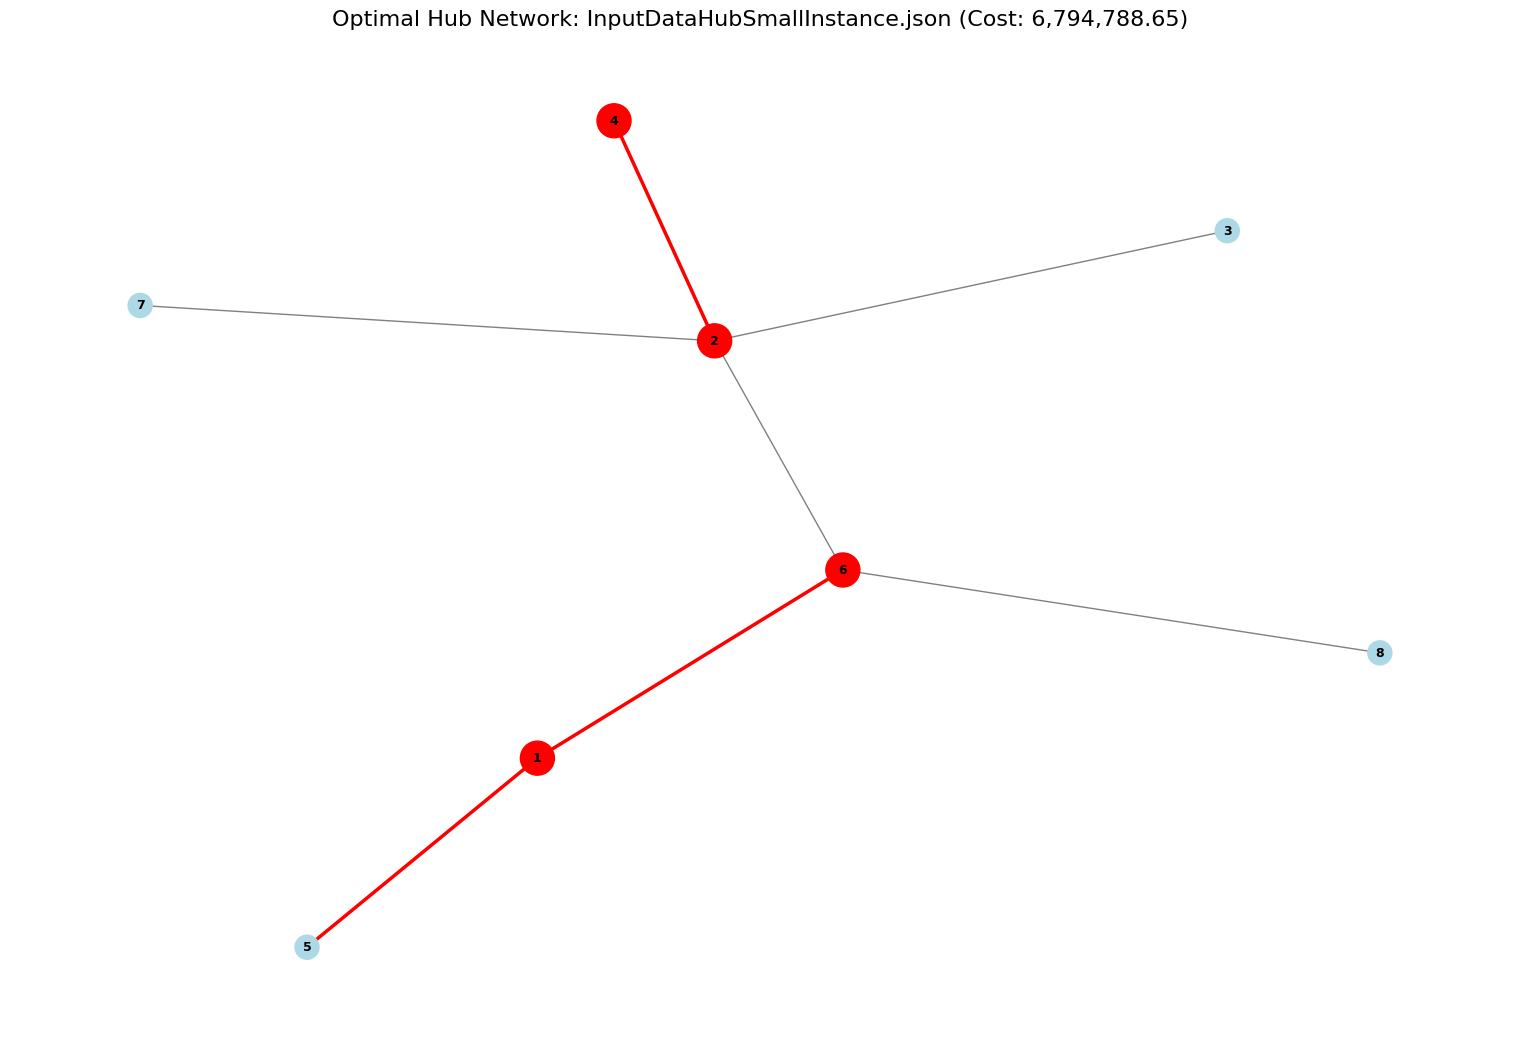


Total execution time for InputDataHubSmallInstance.json: 13.86 seconds.


In [3]:
#%% [markdown]
# Capacitated Single-Allocation Hub Location Problem with Tree Structure
# 
# ## Optimization Model Implementation

#%%
import pulp
import json
import networkx as nx
import matplotlib.pyplot as plt
import time # Added for timing

def solve_hub_problem(input_file):
    """Solve the capacitated hub location problem with tree structure"""
    
    print(f"\n--- Loading and Processing Data for {input_file} ---")
    start_time = time.time()
    
    # Load and process data
    with open(input_file, 'r') as f:
        data = json.load(f)
    
    # Parameters
    nodes = list(range(1, int(data['NodeNum']) + 1))
    n = len(nodes)
    
    # Create parameter dictionaries
    flow = {(i+1, j+1): data['flow(wij)'][i][j] 
            for i in range(n) for j in range(n)}
    cost = {(i+1, j+1): data['varCost(cij)'][i][j] 
            for i in range(n) for j in range(n)}
    fix_cost = {k+1: data['fixCost(fk)'][k] for k in range(n)}
    capacity = {k+1: data['Cap(ckmax)'][k] for k in range(n)}
    alpha = data['alpha']
    
    # Calculate origin flows
    O = {i: sum(flow[(i, j)] for j in nodes) for i in nodes}
    
    print(f"Data loaded in {time.time() - start_time:.2f} seconds.")
    print(f"Number of nodes: {n}")

    #%% [markdown]
    # ### Optimization Model Setup
    
    #%%
    print("--- Setting up Optimization Model ---")
    model_setup_start = time.time()
    
    # Initialize problem
    model = pulp.LpProblem("Hub_Location_Problem", pulp.LpMinimize)
    
    # Decision variables
    # Y: Link between hub k and hub l exists? (k < l)
    Y = pulp.LpVariable.dicts("HubLink", 
                             [(k, l) for k in nodes for l in nodes if k < l], 
                             cat='Binary')
    
    # Z: Node i allocated to hub k? Z[k,k]=1 means k is a hub.
    Z = pulp.LpVariable.dicts("Allocation", 
                             [(i, k) for i in nodes for k in nodes], 
                             cat='Binary')
    
    # X: Flow originating at i, transferred between hub k and hub l
    X = pulp.LpVariable.dicts("Flow", 
                             [(i, k, l) for i in nodes 
                              for k in nodes for l in nodes if k != l], 
                             lowBound=0) # Continuous flow variable
    
    print(f"Variables created in {time.time() - model_setup_start:.2f} seconds.")
    constraints_start = time.time()

    #%% [markdown]
    # ### Objective Function
    
    #%%
    # Fixed costs of opening hubs
    fixed_cost = pulp.lpSum(fix_cost[k] * Z[(k, k)] for k in nodes)
    
    # Collection costs (spoke i to its assigned hub k)
    collection_cost = pulp.lpSum(
        cost[(i, k)] * O[i] * Z[(i, k)] # Cost per unit * total flow from i * if i is assigned to k
        for i in nodes for k in nodes
    )
    
    # Distribution costs (hub l to its assigned spoke j)
    # Sum over all flows (i,j), find hub l for j (Z[j,l]), apply cost (l,j)
    distribution_cost = pulp.lpSum(
        cost[(l, j)] * flow[(i, j)] * Z[(j, l)]
        for i in nodes for j in nodes for l in nodes
    )
    
    # Transfer costs (hub k to hub l with discount)
    # Sum over all flow X(i,k,l) and apply discounted cost alpha*cost(k,l)
    # Note: We sum X(i,k,l) over all origins 'i' for the link (k,l)
    # It's slightly more efficient to calculate total flow on link first, but this works.
    transfer_cost = pulp.lpSum(
        alpha * cost[(k, l)] * X[(i, k, l)]
        for i in nodes for k in nodes for l in nodes if k != l
    )
    
    model += fixed_cost + collection_cost + distribution_cost + transfer_cost, "Total_Cost"
    
    print("Objective function defined.")

    #%% [markdown]
    # ### Constraints
    
    #%%
    print("--- Adding Constraints ---")
    
    # 1. Single allocation constraint: Each node i must be allocated to exactly one hub k.
    print("Adding Constraint 1: Single Allocation...")
    for i in nodes:
        model += pulp.lpSum(Z[(i, k)] for k in nodes) == 1, f"SingleAlloc_{i}"
        
    # 2. Hub link constraints: A link Y(k,l) can only exist if both k and l are hubs (Z[k,k]=1, Z[l,l]=1).
    print("Adding Constraint 2: Hub Link Logic...")
    for k, l in Y: # Iterate directly over Y keys (k < l)
        model += Y[(k, l)] <= Z[(k, k)], f"HubLink_k_{k}_{l}"
        model += Y[(k, l)] <= Z[(l, l)], f"HubLink_l_{k}_{l}"
                
    # 3. Flow routing constraints (Improved Big-M): 
    # Flow X(i,k,l) can only exist if hub link Y(min(k,l), max(k,l)) exists.
    # Use tighter M = O[i] (total flow originating at i).
    print("Adding Constraint 3: Flow Routing (Improved Big-M)...")
    # It's cleaner to iterate through Y keys here as well.
    for i in nodes:
        if O[i] > 0: # Optimization: No need for constraint if no flow originates from i
            for k, l in Y: # Y keys have k < l
                 # Flow from k to l for origin i requires link (k,l)
                model += X[(i, k, l)] <= O[i] * Y[(k, l)], f"FlowRoute_{i}{k}{l}"
                 # Flow from l to k for origin i also requires link (k,l)
                model += X[(i, l, k)] <= O[i] * Y[(k, l)], f"FlowRoute_{i}{l}{k}"
                    
    # 4. Flow conservation at hubs for each origin i:
    # Net flow between hubs for origin i (Out - In) = Flow entering/leaving hub network at k for origin i
    print("Adding Constraint 4: Flow Conservation...")
    for i in nodes:
        for k in nodes:
            # Flow originating at i leaving hub k to other hubs l
            outgoing_hub_flow = pulp.lpSum(X[(i, k, l)] for l in nodes if l != k)
            # Flow originating at i arriving at hub k from other hubs m
            incoming_hub_flow = pulp.lpSum(X[(i, m, k)] for m in nodes if m != k)
            
            # Net flow injected/extracted at hub k for origin i:
            # If i is allocated to k (Z[i,k]=1), it injects O[i] flow.
            # If flow destination j (from i) is also allocated to k (Z[j,k]=1),
            # that flow flow[i,j] does not enter the hub network and is subtracted.
            net_spoke_flow_at_hub = (O[i] * Z[(i, k)] - 
                                     pulp.lpSum(flow[(i, j)] * Z[(j, k)] 
                                                for j in nodes))
                                                
            model += (outgoing_hub_flow - incoming_hub_flow) == net_spoke_flow_at_hub, f"FlowCons_{i}_{k}"
            
    # 5. Capacity constraints: Total flow handled by a hub k cannot exceed its capacity.
    # Flow handled = Flow from allocated spokes + Flow arriving from other hubs
    print("Adding Constraint 5: Hub Capacity...")
    for k in nodes:
        # Total flow arriving at hub k from ALL origins i via ALL other hubs m
        total_incoming_hub_flow = pulp.lpSum(X[(i, m, k)] for i in nodes for m in nodes if m != k)
        
        # Total flow originating from spokes i directly allocated to hub k
        total_direct_spoke_flow = pulp.lpSum(O[i] * Z[(i, k)] for i in nodes)
        
        # Capacity constraint only active if k is a hub (Z[k,k]=1)
        model += (total_incoming_hub_flow + total_direct_spoke_flow) <= capacity[k] * Z[(k, k)], f"Capacity_{k}"
        
    # 6. Tree structure constraint (Simple version): Number of hub links = Number of hubs - 1
    # WARNING: This does NOT guarantee connectivity.
    print("Adding Constraint 6: Tree Structure (Link Count)...")
    model += pulp.lpSum(Y[(k, l)] for k, l in Y) == \
            pulp.lpSum(Z[(k, k)] for k in nodes) - 1, "TreeStructure_LinkCount"
            
    print(f"Constraints added in {time.time() - constraints_start:.2f} seconds.")

    #%% [markdown]
    # ### Solve and Results
    
    #%%
    print("--- Solving the Model ---")
    solve_start = time.time()
    
    # Solve the model using CBC solver. msg=True shows solver output.
    # You might experiment with solver options for large instances, e.g., time limits.
    # solver = pulp.PULP_CBC_CMD(msg=True, timeLimit=3600) # Example: 1 hour time limit
    solver = pulp.PULP_CBC_CMD(msg=True) 
    model.solve(solver)
    
    solve_time = time.time() - solve_start
    print(f"--- Solving Complete (Time: {solve_time:.2f} seconds) ---")
    
    # Results
    print(f"\n{'='*40}\nSolution for {input_file}:")
    print(f"Status: {pulp.LpStatus[model.status]}")
    
    if model.status == pulp.LpStatusOptimal or model.status == pulp.LpStatusFeasible:
        print(f"Optimal Total Cost: {pulp.value(model.objective):,.2f}")
        
        # Identify hubs
        hubs = sorted([k for k in nodes if pulp.value(Z[(k, k)]) > 0.99]) # Use tolerance for floating point
        print(f"Hub Locations: {hubs}")
        
        # Identify allocations
        allocations = {i: k for i in nodes for k in nodes if pulp.value(Z[(i, k)]) > 0.99}
        print("Allocations (Node -> Hub):")
        # Group by hub for clarity
        hub_allocs = {h: [] for h in hubs}
        for node, hub in allocations.items():
             if node not in hubs: # Don't list hubs allocating to themselves
                 hub_allocs[hub].append(node)
        for hub in hubs:
            print(f"  Hub {hub}: {sorted(hub_allocs[hub])}")

        # Identify hub links
        hub_links = [(k, l) for k, l in Y if pulp.value(Y[(k,l)]) > 0.99]
        print(f"Hub Links: {hub_links}")

        #%% [markdown]
        # ### Network Visualization (Optional)
        
        #%%
        print("\n--- Generating Network Visualization ---")
        try:
            # Create graph
            G = nx.Graph()
            
            # Add nodes with colors
            node_colors = ['red' if node in hubs else 'lightblue' for node in nodes]
            node_sizes = [600 if node in hubs else 300 for node in nodes]

            # Add edges
            edges = []
            edge_colors = []
            edge_widths = []
            
            # Hub links (thicker, red)
            for k, l in hub_links:
                edges.append((k, l))
                edge_colors.append('red')
                edge_widths.append(2.5)
                
            # Allocations (thinner, gray)
            for node, hub in allocations.items():
                if node != hub: # Don't draw self-loops for hubs
                    edges.append((node, hub))
                    edge_colors.append('gray')
                    edge_widths.append(1.0)
            
            G.add_nodes_from(nodes)
            G.add_edges_from(edges)
            
            # Draw
            plt.figure(figsize=(15, 10)) # Larger figure size
            # Use a layout that spreads nodes out better, e.g., Kamada-Kawai or Fruchterman-Reingold
            # pos = nx.spring_layout(G, seed=42, k=0.5) 
            pos = nx.kamada_kawai_layout(G) 
            
            nx.draw(G, pos, 
                   node_color=node_colors,
                   node_size=node_sizes,
                   edge_color=edge_colors,
                   width=edge_widths,
                   with_labels=True,
                   font_size=9,
                   font_weight='bold')
            plt.title(f"Optimal Hub Network: {input_file} (Cost: {pulp.value(model.objective):,.2f})", fontsize=16)
            plt.show()
        except Exception as e:
            print(f"Could not generate plot: {e}")

    else:
        print("No optimal solution found.")

    total_time = time.time() - start_time
    print(f"\nTotal execution time for {input_file}: {total_time:.2f} seconds.")
    return model # Return the model object if needed later


#%% [markdown]
# ### Execute Both Instances

#%%
# Solve small instance
print("\n" + "="*60)
print("Solving Small Instance...")
print("="*60)
model_small = solve_hub_problem('InputDataHubSmallInstance.json')
